# Average Treatment Effect of Covid on Technology Stocks: A DID Approach

In our analysis, we try to estimate the ATE of technology sector due to the covid-19 pandemic

## Importing Modules

In [40]:
import pandas as pd
import numpy as np
import datetime as dt
from scipy.stats import shapiro, describe, ttest_rel, ks_2samp, jarque_bera
from arch.unitroot import PhillipsPerron
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-pastel')
import yfinance as yf

## 1. Data

### 1.1 Downloading Data

We downloaded the following data from Yahoo Finance:
* 'VGT': "Vanguard Information Technology Index Fund",
* "^TNX": "10Y Bond Yields",
* 'DX-Y.NYB': "US Dollar Index",
* '^GSPC': "S&P500 Index"

The remaining data is sourced from FRED.

The frequency of our data is daily

In [55]:
tickers = {
        'VGT': "Vanguard Information Technology Index Fund",
        "^TNX": "10Y Bond Yields",
        'DX-Y.NYB': "US Dollar Index",
        '^GSPC': "S&P500 Index"
        }

df = yf.download(list(tickers.keys()), start = '2017-01-01')['Close']
df.columns = ['DXY', 'TECH', 'SPX', 'BOND_YIELDS']
print(df.head())

[*********************100%***********************]  4 of 4 completed
                   DXY        TECH          SPX  BOND_YIELDS
Date                                                        
2017-01-03  103.209999  122.459999  2257.830078        2.450
2017-01-04  102.699997  123.199997  2270.750000        2.452
2017-01-05  101.519997  123.290001  2269.000000        2.368
2017-01-06  102.220001  124.419998  2276.979980        2.418
2017-01-09  101.930000  124.639999  2268.899902        2.376


In [56]:
df1 = pd.read_csv("data/VGT.csv", index_col = 0)
df2 = pd.read_csv("data/T10YIE.csv", index_col =0)
df1.index = pd.to_datetime(df1.index)
df2.index = pd.to_datetime(df2.index)
df1 = df1.resample('1B').asfreq().fillna(0)
df2 = df2[df2['T10YIE'] != '.'].resample('1B').asfreq().ffill()
df2 = df2.astype('float64')

### 1.2 Cleaning Data

We aggregate and merge all our data into a single dataframe and assign a pandemic dummy variable

For our stocks, we take the percentage return of the index

In [137]:
# Normalise Data between 0 and 1
def normalise(series):

    return (series - series.min()) / (series.max() - series.min())

In [138]:
dataframe = pd.concat([df, df1, df2], axis=1, join = 'inner')

dataframe = dataframe[['TECH', 'Dividends', 'SPX', 'BOND_YIELDS', 'DXY', 'T10YIE']]
covid_indicator = [1 if x.date() > dt.datetime(2020, 6, 1).date() else 0 for x in dataframe.index ]
dataframe['COVID_DUMMY'] = covid_indicator

# dataframe['TECH'] = normalise(dataframe['TECH'])
# dataframe['SPX'] = normalise(dataframe['SPX'])
#
# dataframe.drop(dataframe.index[dataframe['TECH'] == 0],inplace=True)
# dataframe.drop(dataframe.index[dataframe['SPX'] == 0], inplace=True)

# dataframe['TECH'] = np.log(dataframe['TECH'].shift(1) / dataframe['TECH'])
# dataframe['SPX'] = np.log(dataframe['SPX'].shift(1) / dataframe['SPX'])

# dataframe['TECH'] = np.log(dataframe['TECH'])
# dataframe['SPX'] = np.log(dataframe['SPX'])

dataframe['TECH'] = dataframe['TECH'].pct_change(1)
dataframe['SPX'] = dataframe['SPX'].pct_change(1)

dataframe.dropna(inplace = True)

## 2. Statistical Tests

We first look at the statistics for our index variables

We conduct the following statistical tests:
* T-Test for 2 dependent samples:  for checking if the means of the two samples are statistically different from each other or not
* The Kolmogorov-Smirnov test for 2 samples: for checking if the two samples are drawn from the same underlying CDF
* The Shapiro-Wilk test for normality
* The Phillips-Perron test for stationarity

### 2.1 Sample Statistics

In [139]:
def describe_data(series):
    result = describe(series)

    return {
            'nobs': result.nobs,
            'min': result.minmax[0],
            'max': result.minmax[1],
            'mean': result.mean,
            'variance': result.variance,
            'skewness': result.skewness,
            'kurtosis': result.kurtosis,
            }

In [140]:
print(pd.DataFrame(data = describe_data(dataframe['TECH']), index = [0]))

   nobs       min      max      mean  variance  skewness  kurtosis
0  1499 -0.134863  0.11014  0.000798  0.000271 -0.275006  7.912528


In [141]:
print(pd.DataFrame(data = describe_data(dataframe['SPX']), index = [0]))

   nobs       min       max      mean  variance  skewness   kurtosis
0  1499 -0.119841  0.093828  0.000445  0.000161 -0.552467  14.338398


### 2.2 T-Test

In [142]:
print(ttest_rel(dataframe['TECH'], dataframe['SPX']))

TtestResult(statistic=2.140079002690093, pvalue=0.032509505076408235, df=1498)


### 2.3 Kolmogorov-Smirnov test

In [143]:
# Have to keep the alternative in mind as the location and scale will also matter, might need to standarise/normalise
print(ks_2samp(dataframe['TECH'], dataframe['SPX']))

KstestResult(statistic=0.08939292861907938, pvalue=1.2403901143567908e-05, statistic_location=0.004307419569164139, statistic_sign=-1)


### 2.4 Shapiro-Wilk Test

In [144]:
print(shapiro(dataframe[['SPX']]))

ShapiroResult(statistic=0.8562328815460205, pvalue=6.517028498651963e-35)


In [145]:
print(shapiro(dataframe['TECH']))

ShapiroResult(statistic=0.9175622463226318, pvalue=7.917896668874415e-28)


### 2.5 Phillips Perron Test

In [146]:
print(PhillipsPerron(dataframe['TECH']).summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -45.622
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## 3. Regression

### 3.1 Making regression dataset

In [204]:
dataframe.dropna(inplace=True)

dataframe_tech = dataframe[dataframe.columns.difference(['SPX'])]
dataframe_tech['TECH_DUMMY'] = [1 for x in dataframe_tech.index]
dataframe_market = dataframe[dataframe.columns.difference(['TECH'])]
dataframe_market['TECH_DUMMY'] = [0 for x in dataframe_market.index]

dataframe_market.rename(columns= {'SPX': 'Returns'}, inplace=True)
dataframe_tech.rename(columns= {'TECH': 'Returns'}, inplace=True)

#### Incase we want alternate observations to remove duplicate covariates

In [205]:
# dataframe_tech = dataframe_tech[[True if x % 2 == 0 else False for x in range(len(dataframe_tech))]]
# dataframe_market = dataframe_market[[True if x % 2 == 1 else False for x in range(len(dataframe_market))]]

In [206]:
dataset = pd.concat([dataframe_market, dataframe_tech], axis=0, join = 'outer').sort_index()

# Adding interaction term which will be our ATE
dataset['COVID_DUMMY.TECH_DUMMY'] = dataset['COVID_DUMMY'] * dataset['TECH_DUMMY']

In [207]:
dataset.to_csv('data/dataset.csv')
dataset.to_stata('data/dataset.dta')

/var/folders/t6/2vvjnfk10mx932fmzp_hb4wr0000gn/T/ipykernel_92439/1359466805.py:2: InvalidColumnName: 
Not all pandas column names were valid Stata variable names.
The following replacements have been made:

    COVID_DUMMY.TECH_DUMMY   ->   COVID_DUMMY_TECH_DUMMY

If this is not what you expect, please make sure you have Stata-compliant
column names in your DataFrame (strings only, max 32 characters, only
alphanumerics and underscores, no Stata reserved words)

  dataset.to_stata('data/dataset.dta')


In [208]:
dataset

,BOND_YIELDS,COVID_DUMMY,DXY,Dividends,Returns,T10YIE,TECH_DUMMY,COVID_DUMMY.TECH_DUMMY
2017-01-04,2.452,0,102.699997,0.000,0.005722,1.99,0,0
2017-01-04,2.452,0,102.699997,0.000,0.006043,1.99,1,0
2017-01-05,2.368,0,101.519997,0.000,0.000731,1.95,1,0
2017-01-05,2.368,0,101.519997,0.000,-0.000771,1.95,0,0
2017-01-06,2.418,0,102.220001,0.000,0.003517,1.96,0,0
...,...,...,...,...,...,...,...,...
2022-12-13,3.501,1,103.980003,0.000,0.007290,2.24,0,0
2022-12-14,3.503,1,103.769997,0.000,-0.007467,2.19,1,1
2022-12-14,3.503,1,103.769997,0.000,-0.006053,2.19,0,0
2022-12-15,3.450,1,104.559998,0.872,-0.024922,2.16,0,0


### 3.2 Conducting OLS

In [209]:
import statsmodels.api as sm

Y = dataset['Returns']
X = sm.add_constant(dataset[dataset.columns.difference(['Returns'])])
model = sm.OLS(Y, X)

results = model.fit(cov_type = "HC0", use_t = True)
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                    0.7200
Date:                Sun, 12 Feb 2023   Prob (F-statistic):              0.655
Time:                        00:18:09   Log-Likelihood:                 8402.2
No. Observations:                2998   AIC:                        -1.679e+04
Df Residuals:                    2990   BIC:                        -1.674e+04
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

# 4. Exploratory Data Analysis

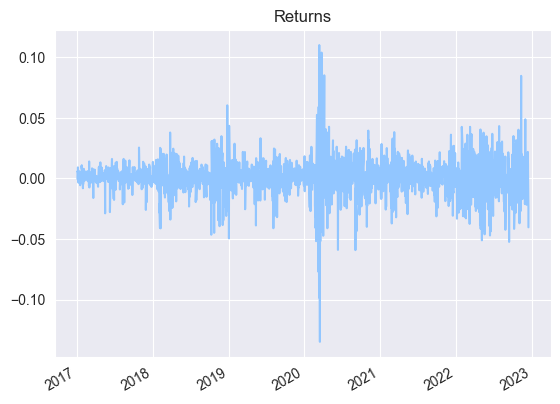

In [210]:
# Time Series plot of our dependent variable
Y.plot(title = 'Returns');

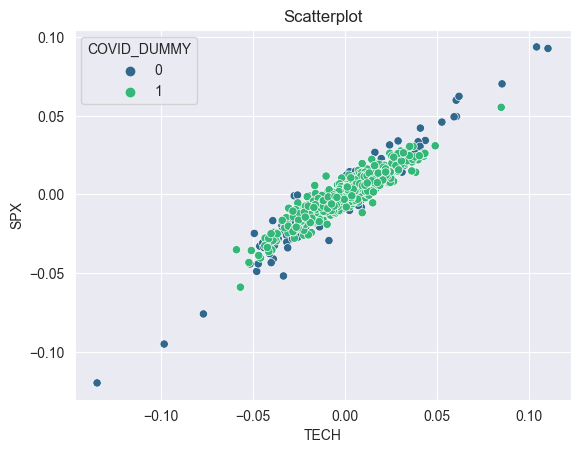

In [211]:
# Scatterplot of SPX returns vs TECH returns colored by covid regime
fig, ax = plt.subplots()
sns.scatterplot(data=dataframe, x = 'TECH', y = 'SPX', hue = 'COVID_DUMMY', palette = 'viridis', ax=ax);
ax.set_title('Scatterplot');

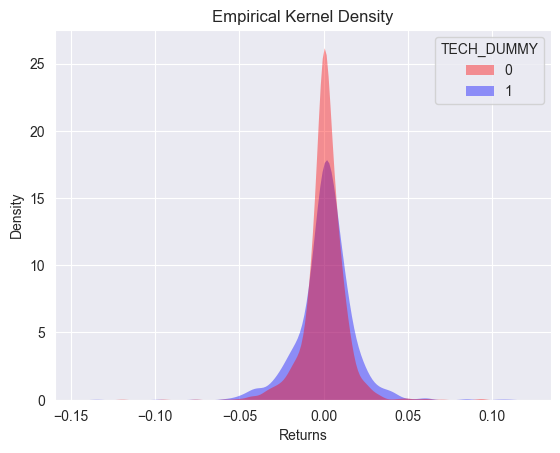

In [212]:
# PDF of our returns variable, colored by whether the returns belong to TECH or SPX
fig, ax = plt.subplots()
sns.kdeplot(
   data=dataset, x="Returns", hue="TECH_DUMMY",
   fill=True, palette = ['red', 'blue'],
   alpha=.4, linewidth=0, clip = (-0.5, 0.5), ax=ax
);
ax.set_title('Empirical Kernel Density');

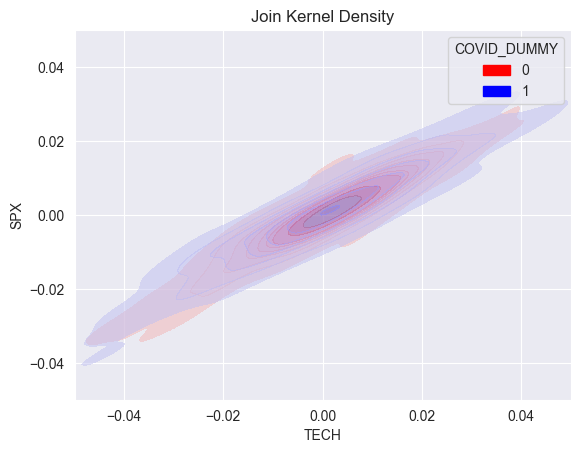

In [213]:
fig, ax = plt.subplots()
sns.kdeplot(
   data=dataframe, x="TECH", y = 'SPX', hue="COVID_DUMMY",
   fill=True, palette=['red', 'blue'],
   alpha=.5, clip = (-0.05, 0.05), ax=ax
)
ax.set_title('Join Kernel Density');